# makemore part 2: MLP

## What is makemore?

Makemore "makes more" of things that you give it. Example uses `names.txt` and makemore learns to make names

Under the hood, makemore is a character-level language model: it treats each line as sequences of individual characters. Model sequence of characters and try to predict next characters in a sequence.

This class will look at 
1. Bigram (one character simply predicts a next one with a lookup table of counts)
2. ~~Bag of Words~~
   1. The table explodes! We'll skip
3. **Multilayer Perceptron**
4. Recurrent Neural Network
5. GRU
6. Transformers

Will build a transformer equivalent to GPT-2, at the level of characters

## Agenda
Characters
Words
Images

---

## External Resources

### Lesson

[Building makemore part 2 (MLP) (youtube)](https://youtu.be/TCH_1BHY58I?si=YckNuBhoxAy5EJ7L)

___

## Import necessary libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

---

In [3]:
# read in all the words
names_data = '../../data/raw/names.txt'

words = open(names_data, 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i  in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)

In [8]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [10]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [11]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [13]:
len(torch.unbind(emb, 1))

3

In [14]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [15]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [16]:
a.shape

torch.Size([18])

In [17]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [18]:
emb.view(32,6)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078],
        [ 0.6772, -0.8404, -0.1158, -1.2078,  0.6772, -0.8404],
        [-0.1158, -1.2078,  0.6772, -0.8404, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.0274, -1.1008],
        [ 1.5674, -0.2373, -0.0274, -1.1008, -0.1158, -1.2078],
        [-0.0274, -1.1008, -0.1158, -1.2

In [20]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [21]:
h.shape

torch.Size([32, 100])

In [24]:
g2 = torch.Generator().manual_seed(2147483648)
W2 = torch.randn((100, 27), generator=g2)
b2 = torch.randn(27, generator=g2)
logits = h @ W2 + b2

In [25]:
logits.shape

torch.Size([32, 27])

In [28]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

In [29]:
probs.shape

torch.Size([32, 27])

In [31]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.8420)

In [33]:
## now cleaner

In [32]:
# dataset
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [38]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [39]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [40]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [42]:
for p in parameters:
    p.requires_grad = True

In [44]:
for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

3.985849380493164
3.6028308868408203
3.262141466140747
2.961380958557129
2.6982972621917725
2.469712734222412
2.271660804748535
2.101283550262451
1.9571768045425415
1.837485909461975
1.7380967140197754
1.6535115242004395
1.579089641571045
1.5117664337158203
1.449604868888855
1.391311764717102
1.3359925746917725
1.2830528020858765
1.2321909666061401
1.18338143825531
1.1367987394332886
1.092664122581482
1.051092505455017
1.0120266675949097
0.9752707481384277
0.9405564665794373
0.907612681388855
0.8761921525001526
0.8460891246795654
0.8171355724334717
0.7891991138458252
0.762174665927887
0.7359815835952759
0.7105579972267151
0.6858609914779663
0.661865234375
0.6385658383369446
0.6159816980361938
0.5941658020019531
0.5732107162475586
0.5532562732696533
0.5344881415367126
0.517116904258728
0.5013313889503479
0.4872426390647888
0.47484031319618225
0.46399760246276855
0.45451435446739197
0.4461709260940552
0.4387664496898651
0.4321332573890686
0.42613887786865234
0.42067980766296387
0.4156754

In [45]:
logits

tensor([[ 3.7364e+00,  1.3243e+01,  5.3936e+00,  4.0986e+00, -7.6481e-01,
          1.3230e+01, -1.8064e+01,  5.7296e+00, -3.5948e+00,  1.3127e+01,
          6.7955e+00, -3.3737e+00, -1.8950e-01,  7.3836e+00,  2.9799e-01,
          1.3206e+01,  3.7032e+00,  6.6959e+00, -7.2974e-01,  1.3342e+01,
         -2.4079e+00,  4.7266e+00,  7.0276e+00, -6.4954e+00,  6.4333e+00,
         -5.4573e+00,  5.9183e+00],
        [-9.0326e+00,  7.5508e+00,  1.9474e+00,  1.4167e+00,  5.6899e+00,
          9.9777e+00, -2.4470e+00,  4.2986e+00,  8.6139e+00, -3.7773e+00,
          1.0314e+01, -9.6408e-01,  1.2337e+01,  1.7807e+01,  5.8896e+00,
          6.2645e+00,  8.7870e+00,  1.9579e+00,  7.4646e+00,  9.4357e+00,
          1.9702e+00, -9.0641e+00, -9.9757e+00, -1.1741e+01,  1.6835e+00,
         -4.0627e+00,  6.2618e+00],
        [ 8.0209e+00,  1.1978e+01,  1.0468e+01,  5.6288e+00, -1.9760e+00,
          5.6125e+00, -9.9576e+00, -8.7411e+00, -1.1284e+01,  1.4135e+01,
          5.7168e+00,  1.1734e+01,  5.33

In [46]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3422, 17.8071, 20.6086, 20.6230, 16.7472, 13.3422, 16.0095, 14.1818,
        15.9242, 18.3747, 15.9525, 20.9386, 13.3422, 17.1232, 17.1448, 20.0736,
        13.3422, 16.6001, 15.1165, 17.0719, 18.5965, 15.9803, 10.8856, 10.6974,
        15.5135, 13.3422, 16.1900, 16.9852, 12.7504, 16.2094, 19.0981, 16.0356],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

Repeat above, but now train on the entire dataset instead of the first 5 names

In [28]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [29]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [50]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.08448600769043
15.776532173156738
14.833345413208008
14.002610206604004
13.253265380859375
12.57992172241211
11.983108520507812
11.470500946044922
11.051865577697754
10.709595680236816
10.407641410827637
10.12781810760498
9.864375114440918
9.61451244354248
9.376447677612305
9.148953437805176
8.931118965148926
8.722238540649414
8.521757125854492
8.32923412322998
8.144330978393555
7.966796875
7.796455383300781
7.633191108703613
7.476912975311279
7.327525615692139
7.184889316558838
7.048793792724609
6.918954372406006
6.79502010345459
6.676605224609375
6.563319206237793
6.454790115356445
6.350668907165527
6.250643253326416
6.154431343078613
6.061784267425537
5.9724812507629395
5.886326313018799
5.803145885467529
5.722782611846924
5.6450934410095215
5.569944381713867
5.497211933135986
5.426778316497803
5.358534336090088
5.292374134063721
5.228201866149902
5.165927410125732
5.105466842651367
5.046746253967285
4.98969841003418
4.934260368347168
4.8803791999816895
4.82800

KeyboardInterrupt: 

I interrupted the previous cell because each iteration takes a while, and Andrej comments on this as well! He mentions that in real situations, we can't train on all data at once, and we take mini batches and train on those.

In [52]:
torch.randint(0,X.shape[0],(32,))

tensor([130749,  57091,  49430, 191573, 134670, 173976, 100412, 106859,  69962,
         73525, 112094,  81475, 141409, 182816, 200439, 122960, 185422, 198721,
        105378, 124923, 206892, 122831,  96682, 208871, 112691,  74257,  83031,
         66554,  35890, 210604,   4903, 154765])

In [8]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())


2.427752733230591


SO FAST!

Minibatches are much much faster, but the quality of gradient is not as good. However, you take so many batches that are generally good enough that it's better to minibatch with more steps

In [57]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6695, grad_fn=<NllLossBackward0>)

For next time, start at 45:53, we are trying to find a good learning rate. How? Messing around for this example shows it's between 0.001 and 1

In [19]:
torch.linspace(0.001, 1, 1000) #creates 1000 numbers between 0.001 and 1
# however, this doesn't really make any sense as it's too fine

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# here we're going 10 to the power of as these make more sense

In [20]:
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lossi.append(loss.item())

# print(loss.item())


16.39183235168457
18.914222717285156
16.7376708984375
16.911823272705078
19.48582649230957
23.84551429748535
21.115474700927734
19.122961044311523
18.848459243774414
19.336130142211914
20.664203643798828
17.279735565185547
21.554107666015625
19.158344268798828
22.902414321899414
19.619834899902344
19.47692108154297
15.603148460388184
20.946495056152344
18.630109786987305
18.464967727661133
18.282608032226562
18.84685707092285
18.10394859313965
18.24261474609375
18.418691635131836
19.189361572265625
18.83200454711914
17.483989715576172
18.770442962646484
19.014358520507812
16.4473819732666
18.111003875732422
18.53852081298828
17.236774444580078
19.244131088256836
19.343505859375
19.825868606567383
20.024831771850586
18.584766387939453
20.28449249267578
17.32353401184082
17.67972183227539
20.449316024780273
19.787891387939453
17.462085723876953
16.646028518676758
16.452014923095703
17.568832397460938
16.934797286987305
17.32684326171875
17.39684295654297
17.179811477661133
17.65085983276

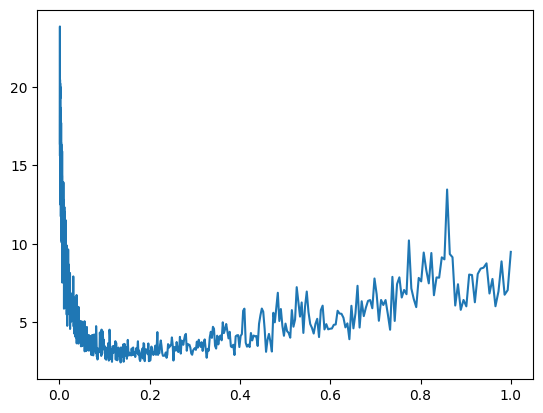

In [21]:
plt.plot(lri, lossi);

Looks like it's pretty good at around 0.1!

In [30]:
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

for _ in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5091, grad_fn=<NllLossBackward0>)

Loss keeps going down, but remember to watch out for over fitting!

In [ ]:
# training split, dev/validation split, test split
# usually used for training parameters, training hyperparameters, evaluate the model
# 80 / 10 / 10
# test loss sparingly!

In [31]:
# build the dataset but via a function instead

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [32]:
Xtr.shape, Ytr.shape #dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [36]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [37]:
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

for i in range(35000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lossi.append(loss.item())
    
print(loss.item())

2.6250922679901123


In [38]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4006, grad_fn=<NllLossBackward0>)

In [39]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3997, grad_fn=<NllLossBackward0>)

Since the training and dev losses are roughly equal, we are not overfitting the training data. We think we can improve the model but increasing the size of the neural net!

In [40]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

10281


In [41]:
lri = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(35000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.item())
    stepi.append(i)
    
# print(loss.item())

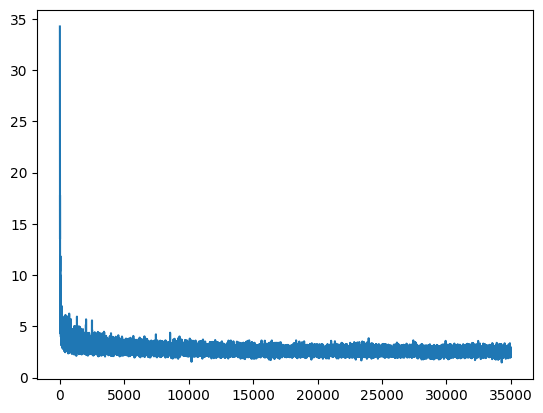

In [42]:
plt.plot(stepi, lossi);

The thickness in the plot is due to us using minibatches, which creates some noise

In [43]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4786, grad_fn=<NllLossBackward0>)

In [44]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4876, grad_fn=<NllLossBackward0>)

Want to do more training, but it's possible that we only see noise. Fix is to increase the size of the minibatches to lower the amount of thrashing about and truly optimize the parameters/hyper parameters

In the video, the loss isn't decreasing that much despite using more layers. We may be starting with embeddings that aren't helpful enough. Too many characters getting mashed into 2 dimensions

In [45]:
lri = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(100000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.item())
    stepi.append(i)
    
# print(loss.item())

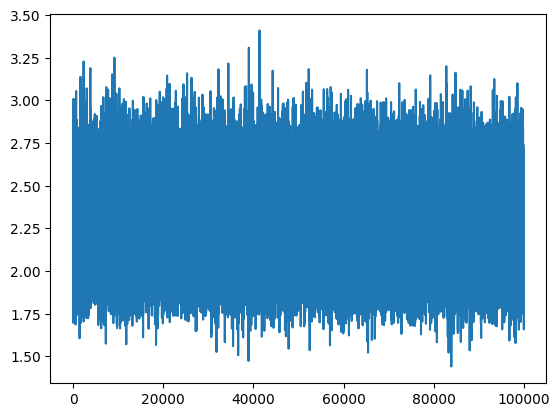

In [46]:
plt.plot(stepi, lossi);

In [47]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2773, grad_fn=<NllLossBackward0>)

In [48]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2733, grad_fn=<NllLossBackward0>)

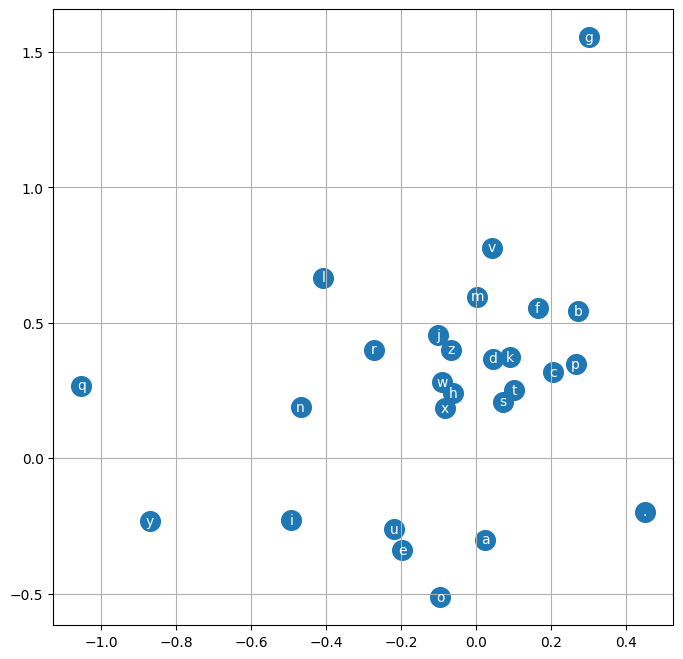

In [50]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200);
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

The plot allows you to see if there's any sort of clustering or structure in the embeddings. In the video (which had a longer trained model), the vowels were clustered pretty close together, implying that they are interchangeable. q and . were separate from the other characters.

We'll change the embedding dimension to more than 2, but this means we can't visualize as easily

In [51]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

11897


In [52]:
lri = []
lossi = []
stepi = []

In [53]:
for p in parameters:
    p.requires_grad = True

for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    
# print(loss.item())

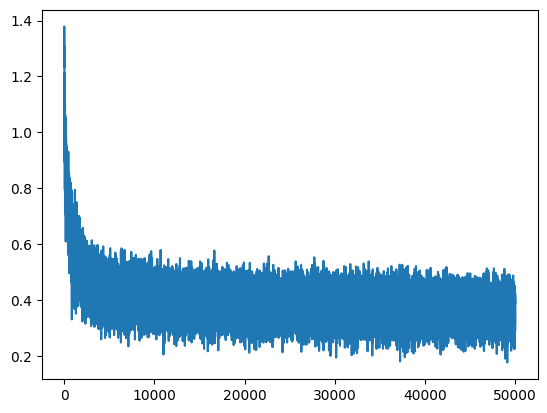

In [54]:
plt.plot(stepi, lossi);

In [55]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3497, grad_fn=<NllLossBackward0>)

In [56]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3833, grad_fn=<NllLossBackward0>)

In [57]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    

In production, we would create hyperparamters and run experiments on all these settings

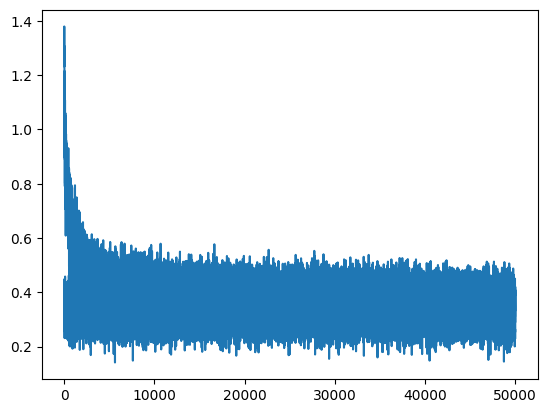

In [58]:
plt.plot(stepi, lossi);

In [59]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1707, grad_fn=<NllLossBackward0>)

In [60]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1969, grad_fn=<NllLossBackward0>)

These are slowly starting to deviate.

There's a few more minutes of trying to get the log loss below 2

How to improve?
1. Change number of neurons in the hidden layer
2. Change dimensionality of embedding/lookup table
3. Change number of characters being fed in as context
4. Change number of steps, learning rate, batch size
5. Read the paper that's cited!